In [63]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.nn as nn
import timm
from einops import rearrange, repeat, reduce
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from src.main.models.VitAttentionScore import *
from src.main.utils.model_utils import *
from src.main.utils.utils import bind
from src.main.config.config_factory import ConfigFactory


mc, tc = ConfigFactory(model_name="VitAttentionScore")

model_name = "vit_base_patch16_384"
model_official = timm.create_model(model_name, pretrained=True)
model_official.eval()
save_model(model_official)

model_custom = VitAttentionScore(**bind(VitAttentionScore, mc.to_dict()))
model_custom.eval()



VitAttentionScore(
  (embedding): Embedding(
    (patch_enbedding): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('B C P1 P2 -> B (P1 P2) C')
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (0): Sequential(
      (Transformer_0_Attention): ResidualBlock(
        (net): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_weight): Softmax(dim=-1)
            (attn_weight_dropout): Dropout(p=0.1, inplace=False)
            (proj): Sequential(
              (0): Linear(in_features=768, out_features=768, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
      )
      (Transformer_0_MLPBlock): ResidualBlock(
        (net): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         

In [65]:
for (n_o, p_o), (n_c, p_c) in zip(model_official.named_parameters(), model_custom.named_parameters()):
    if p_o.numel() != p_c.numel():
        break

    p_c.data[:] = p_o.data



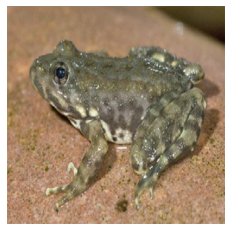

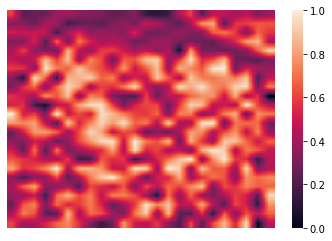

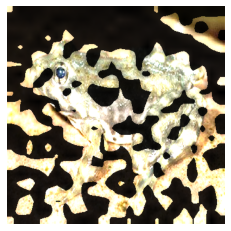

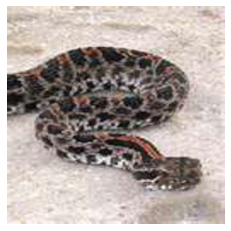

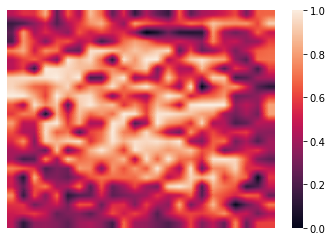

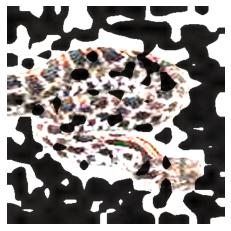

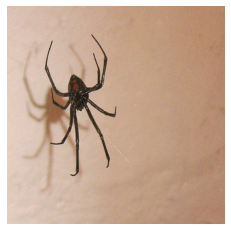

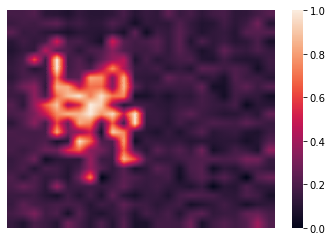

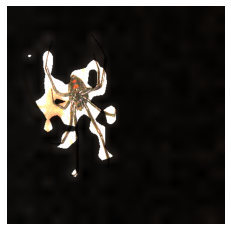

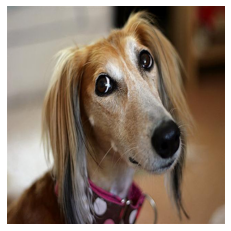

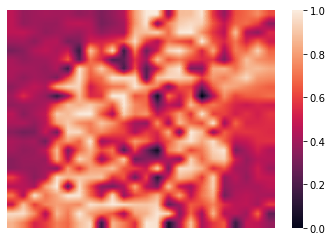

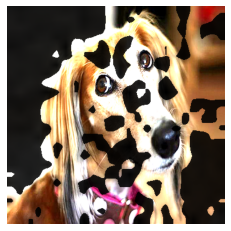

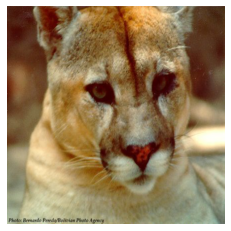

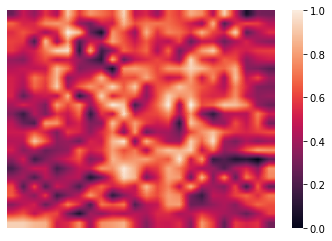

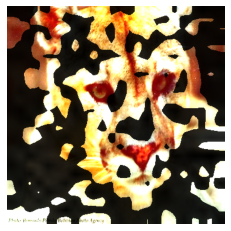

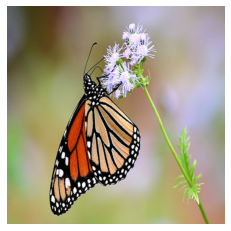

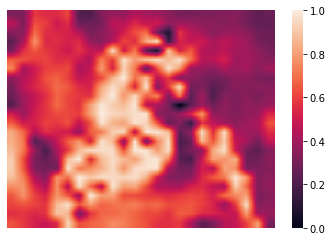

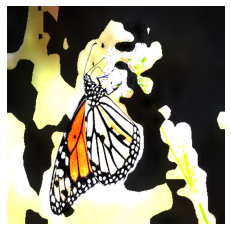

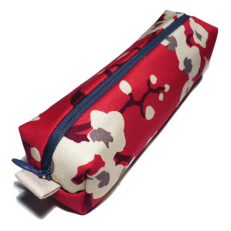

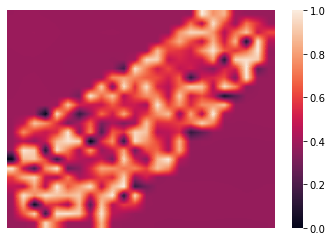

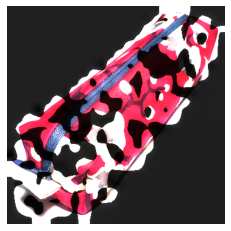

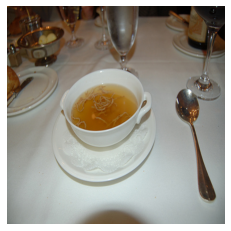

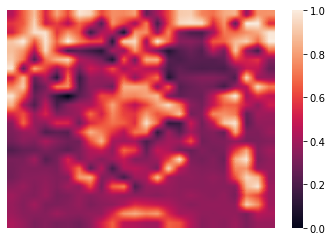

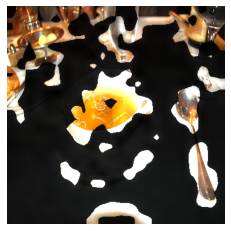

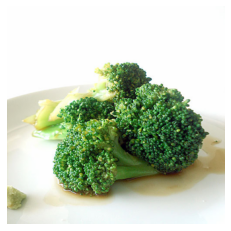

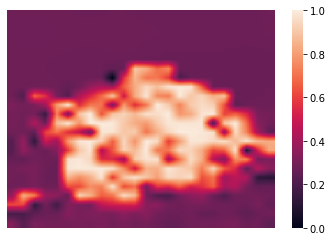

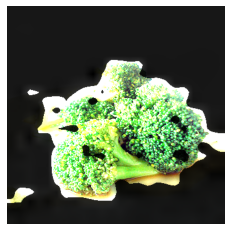

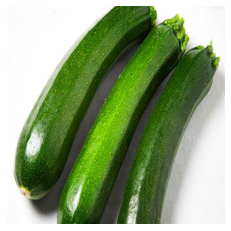

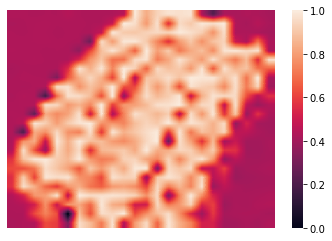

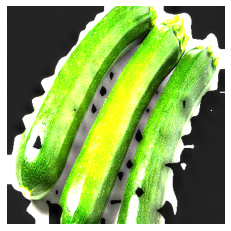

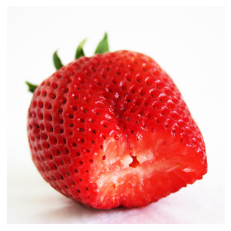

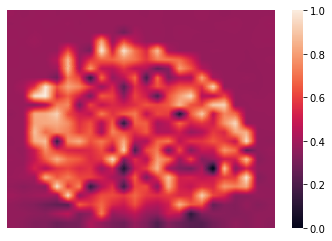

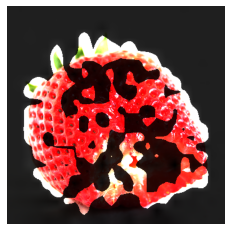

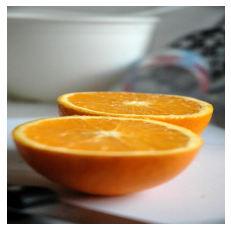

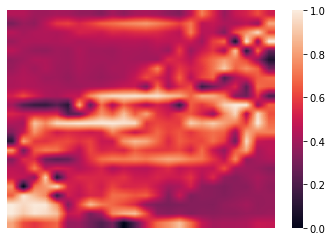

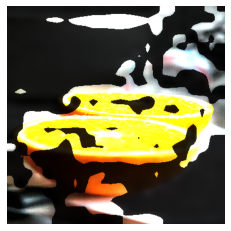

UnidentifiedImageError: cannot identify image file 'img/original/Thumbs.db'

In [76]:
path='img/original/'
path_heat='img/heat/'
path_att='img/attention/'
path_reshape='img/reshape/'
for imgfile in os.listdir(path):
    with torch.no_grad():

        # reshape the image and change it to float tensor
        img_width, img_height = 384, 384
        patch_size = 16
        patch_num_width = img_width // patch_size
        patch_num_height = img_height // patch_size
        head_num = 12
        inp = torch.from_numpy(np.array(Image.open(path+imgfile).resize([img_width, img_height]))) * 1.
        
        plt.imshow(Image.open(path+imgfile).resize([img_width, img_height]))
        plt.axis('off')
        plt.savefig(path_reshape+imgfile[:-5]+'_reshape.jpg',bbox_inches='tight')
        plt.show()
        
        # reshape image to B C H W
        # h: image width = 384, w: image height = 384, c: image channel = 3
        inp = rearrange(inp, "h w c -> 1 c h w")
        # b: batch size = 1, c: channel = 3, p1, p2: patch size = 16, n1, n2: num patch per direction = 24

        # get the attention weight
        # shape of weights: [batch size = 1, num head = 12, cls token + num patch = 1 + 24*24, cls token + num patch = 1 + 24*24]
        weights = model_custom(inp)
        # for every head, take all patch except cls token
        # shape of weight: [num head = 12, num patch = 24*24, num patch = 24*24]
        weight = weights[0, :, 1:, 1:]
        # take the average over the 2-th axis
        # to get weight of each patch
        # shape of wweight: [num head = 12, num patch = 24*24]
        weight = weight.mean(dim=-1).reshape(head_num, -1) # TODO: why dim=-1 ? should be dim=-2 but dim=-1 works better.

        # reshape the weight tensor to have the same height and width with image
        weight = rearrange(weight, "n (h w) -> n h w", h=24)
        weight = nn.functional.interpolate(weight.unsqueeze(0), scale_factor=16, mode="bilinear", align_corners=False)[0] # 12, 384, 384

        # reshape the input back to image shape
        inp = rearrange(inp, "1 c h w -> h w c")
        # normalise weights in each head to be in interval [0, 1]
        # weight = weight - reduce(weight, "n h w -> n () ()", reduction="min")
        # weight /= (reduce(weight, "n h w -> n () ()", reduction="max") - reduce(weight, "n h w -> n () ()", reduction="min"))

        mask = weight.mean(0)
        mask -= mask.min()
        mask /= (mask.max() - mask.min())
        seaborn.heatmap(mask)
        plt.axis('off')
        plt.savefig(path_heat+imgfile[:-5]+'_heat.jpg',bbox_inches='tight')
        plt.show()
        mask = repeat(mask.unsqueeze(-1), "h w 1 -> h w 3").numpy()
        mask[mask>0.55]*=3
        mask[mask<=0.55]/=3
        inp *= (mask)
        inp[inp>255]=255
        plt.imshow(inp.detach().numpy().astype("int"))
        plt.axis('off')
        plt.savefig(path_att+imgfile[:-5]+'_att.jpg',bbox_inches='tight')
        plt.show()


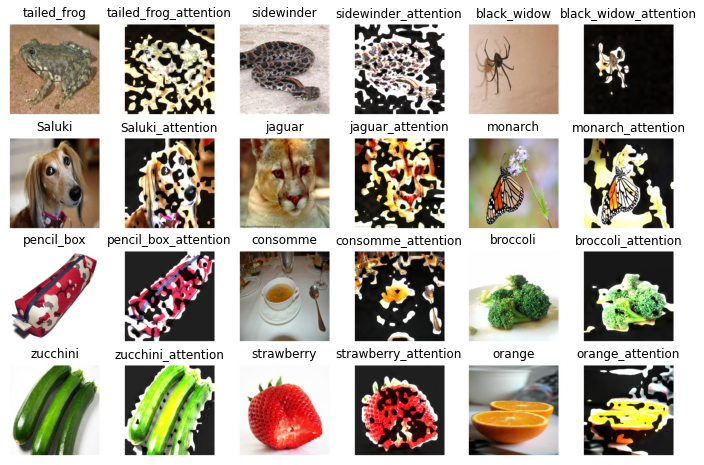

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
fig, axs = plt.subplots(4,6,figsize=(12,8))
path='img/original/'
path_heat='img/heat/'
path_att='img/attention/'
path_reshape='img/reshape/'
i = -1
j = 0
n = 0

for imgfile in os.listdir(path_reshape):
    if imgfile.find('.jpg')==-1:
        continue
    if n%3 ==0:
        i+=1
        j=0
    else:
        j+=2
    label = imgfile[imgfile.find('_')+1:-12]
    axs[i,j].set_title(label)
    axs[i,j].imshow(Image.open(path_reshape+imgfile))
    axs[i,j].axis('off')
    axs[i,j+1].set_title(label+'_attention')
    axs[i,j+1].imshow(Image.open(path_att+imgfile.replace('reshape','att')))
    axs[i,j+1].axis('off')
    n+=1
plt.savefig('img/comparision.jpg',bbox_inches='tight')
plt.show()